In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from lsst.rsp import get_tap_service, retrieve_query
import gc
import os

# Astropy
import astropy.units as u
from astropy.units import UnitsWarning
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [2]:
#initializing Tap and Butler
pd.set_option('display.max_rows', 20)
warnings.simplefilter("ignore", category=UnitsWarning)
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [3]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get('skyMap')
image_size = 100 #pixels

## explore tables, columns, and datasets available

In [4]:
#print all the available dataset types
# for dt in sorted(butler.registry.queryDatasetTypes('calexp*')):
#     print(dt)

DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF)
DatasetType('calexpBackground', {band, instrument, detector, physical_filter, visit_system, visit}, Background)
DatasetType('calexpCutoutTask_config', {}, Config)
DatasetType('calexpCutoutTask_log', {band, instrument, detector, physical_filter, visit_system, visit}, ButlerLogRecords)
DatasetType('calexpCutoutTask_metadata', {band, instrument, detector, physical_filter, visit_system, visit}, PropertySet)
DatasetType('calexp_camera', {band, instrument, physical_filter, visit_system, visit}, ImageF)
DatasetType('calexp_cutouts', {band, instrument, detector, physical_filter, visit_system, visit}, Stamps)


In [5]:
# query = "SELECT * FROM tap_schema.schemas"
# results = service.search(query).to_table()
# results

description,schema_index,schema_name,utype
str512,int32,str64,str512
Data Preview 0.1 includes five tables based on the DESC's Data Challenge 2 simulation of 300 square degrees of the wide-fast-deep LSST survey region after 5 years. All tables contain objects detected in coadded images.,2,dp01_dc2_catalogs,
"Data Preview 0.2 contains the image and catalog products of the Rubin Science Pipelines v23 processing of the DESC Data Challenge 2 simulation, which covered 300 square degrees of the wide-fast-deep LSST survey region over 5 years.",0,dp02_dc2_catalogs,
ObsCore v1.1 attributes in ObsTAP realization,1,ivoa,
A TAP-standard-mandated schema to describe tablesets in a TAP 1.1 service,100000,tap_schema,
UWS Metadata,120000,uws,


In [6]:
# schema_names = results['schema_name']
# for name in schema_names:
#     if name.find('dp02') > -1:
#         dp02_schema_name = name
#         break
# print("DP0.2 schema is " + dp02_schema_name)

DP0.2 schema is dp02_dc2_catalogs


In [7]:
# query = "SELECT * FROM tap_schema.tables " \
#         "WHERE tap_schema.tables.schema_name = '" \
#         + dp02_schema_name + "' order by table_index ASC"
# print(query)

# results = service.search(query)
# results = results.to_table()
# results

SELECT * FROM tap_schema.tables WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs' order by table_index ASC


description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
Properties of the astronomical objects detected and measured on the deep coadded images.,dp02_dc2_catalogs,1,dp02_dc2_catalogs.Object,table,
"Properties of detections on the single-epoch visit images, performed independently of the Object detections on coadded images.",dp02_dc2_catalogs,2,dp02_dc2_catalogs.Source,table,
"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,
Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",dp02_dc2_catalogs,6,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,
"Metadata about the pointings of the DC2 simulated survey, largely associated with the boresight of the entire focal plane.",dp02_dc2_catalogs,7,dp02_dc2_catalogs.Visit,table,
Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,


In [8]:
# def get_columns_from_table(table_name):
#     results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = "+table_name+" ")
#     df_table = results.to_table().to_pandas()
#     column_names = df_table['column_name'].to_list()
#     return column_names

In [9]:
# results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'")
# df_ccdvisit_table = results.to_table().to_pandas()
# df_ccdvisit_table['column_name'].to_list()

['band',
 'ccdVisitId',
 'darkTime',
 'decl',
 'detector',
 'expMidpt',
 'expMidptMJD',
 'expTime',
 'llcdec',
 'llcra',
 'lrcdec',
 'lrcra',
 'obsStart',
 'obsStartMJD',
 'physical_filter',
 'psfSigma',
 'ra',
 'seeing',
 'skyBg',
 'skyNoise',
 'skyRotation',
 'ulcdec',
 'ulcra',
 'urcdec',
 'urcra',
 'visitId',
 'xSize',
 'ySize',
 'zenithDistance',
 'zeroPoint']

In [10]:
# results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs.ForcedSource'")
# df_forcedsrc_table = results.to_table().to_pandas()
# df_forcedsrc_table['column_name'].to_list()

['band',
 'ccdVisitId',
 'coord_dec',
 'coord_ra',
 'detect_isPatchInner',
 'detect_isPrimary',
 'detect_isTractInner',
 'forcedSourceId',
 'localBackground_instFlux',
 'localBackground_instFluxErr',
 'localPhotoCalib',
 'localPhotoCalib_flag',
 'localPhotoCalibErr',
 'localWcs_CDMatrix_1_1',
 'localWcs_CDMatrix_1_2',
 'localWcs_CDMatrix_2_1',
 'localWcs_CDMatrix_2_2',
 'localWcs_flag',
 'objectId',
 'parentObjectId',
 'patch',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'psfDiffFlux',
 'psfDiffFlux_flag',
 'psfDiffFluxErr',
 'psfFlux',
 'psfFlux_flag',
 'psfFluxErr',
 'skymap',
 'tract']

## variable stars

In [10]:
def get_cutout_image(ra_deg,dec_deg,visit,detector,band,datasetType='calexp',cutoutSideLength=image_size):
    """
    get the tract and patch of a source. currently retrieves i band only. 

    Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    radec = geom.SpherePoint(ra_deg,dec_deg, geom.degrees)
    
    dataId = {'visit': visit, 'detector': detector}  
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

def make_fig(cutout_image, ra, dec, out_name):
    """
    Create an image.
    should be followed with remove_figure

    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    out_name : file name where you'd like to save it
    
    """
    fig = plt.figure(figsize=(4, 4))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(cutout_image.image)
    
    cutout_wcs = cutout_image.getWcs()
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
    afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
    plt.gca().axis('off')
    plt.savefig(out_name)
    
    return fig
    
    
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call the garbage collector

In [8]:
plots = []
bands = ['g','r','i']
batch_dir = './variable_stars_test_output'

In [9]:
if os.path.isdir(batch_dir) == False:
    os.mkdir(batch_dir)
    
if os.path.isdir(batch_dir+'/coadd_images') == False:
    os.mkdir(batch_dir+'/coadd_images')
else:
    os.system('rm -r '+batch_dir+'/coadd_images/*')

In [11]:
#Let's look at one RR-Lyrae
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

In [15]:
def query_stars(ra_deg, dec_deg, radius_deg, limit):
    #radius within which you want to query
    
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) <= 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

def query_one_star(ra_deg, dec_deg, radius_deg, limit):
    #radius within which you want to query
    
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) = 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

In [16]:
%%time
#variable_stars = query_stars(ra_known_rrl, dec_known_rrl, 0.001,10)
variable_stars = query_one_star(ra_known_rrl, dec_known_rrl, 0.001,10)

CPU times: user 48.2 ms, sys: 2.31 ms, total: 50.5 ms
Wall time: 5.64 s


In [17]:
variable_stars

,id_truth_type,match_objectId,ra,dec
0,835714_2,1651589610221899038,62.147903,-35.799138


## Querying visit id and detector information for one source based on object ID

In [34]:
ccd_query = "SELECT src.coord_ra, src.coord_dec, src.objectId, "\
        "ccdvis.detector, ccdvis.visitId, ccdvis.ccdVisitId, ccdvis.expMidptMJD "\
        "FROM dp02_dc2_catalogs.ForcedSource AS src "\
        "JOIN dp02_dc2_catalogs.CcdVisit AS ccdvis "\
        "ON src.ccdVisitId = ccdvis.ccdVisitId "\
        "WHERE src.objectId = "+str(1651589610221899038)+" "
ccd_results = service.search(ccd_query)

In [35]:
ccd_results = ccd_results.to_table().to_pandas()

In [36]:
ccd_results

,coord_ra,coord_dec,objectId,detector,visitId,ccdVisitId,expMidptMJD
0,62.147902,-35.799138,1651589610221899038,46,414861,414861046,60166.333170
1,62.147902,-35.799138,1651589610221899038,112,718818,718818112,60643.066952
2,62.147902,-35.799138,1651589610221899038,129,943324,943324129,60961.245729
3,62.147902,-35.799138,1651589610221899038,140,943325,943325140,60961.246178
4,62.147902,-35.799138,1651589610221899038,47,414892,414892047,60166.347131
...,...,...,...,...,...,...,...
427,62.147902,-35.799138,1651589610221899038,73,686593,686593073,60596.238301
428,62.147902,-35.799138,1651589610221899038,4,1165692,1165692004,61286.258406
429,62.147902,-35.799138,1651589610221899038,91,1165691,1165691091,61286.257958
430,62.147902,-35.799138,1651589610221899038,148,686629,686629148,60596.254539


In [23]:
image_r = get_cutout_image(62.147902,-35.799138,414861,46, 'r',datasetType='calexp',cutoutSideLength=100)
image_g = get_cutout_image(62.147902,-35.799138,414861,46, 'g',datasetType='calexp',cutoutSideLength=100)
image_i = get_cutout_image(62.147902,-35.799138,414861,46, 'i',datasetType='calexp',cutoutSideLength=100)

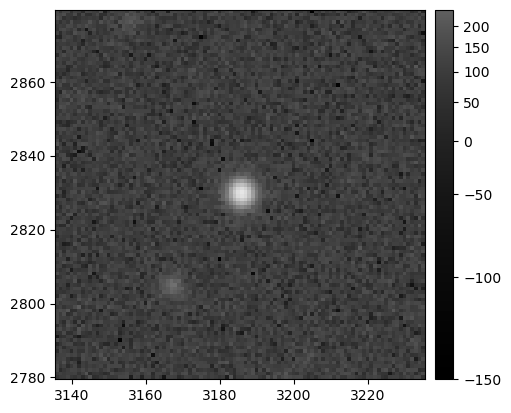

In [27]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(image_r.image)
plt.show()

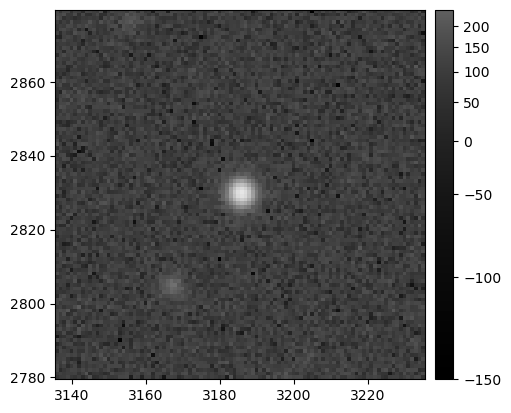

In [28]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(image_g.image)
plt.show()

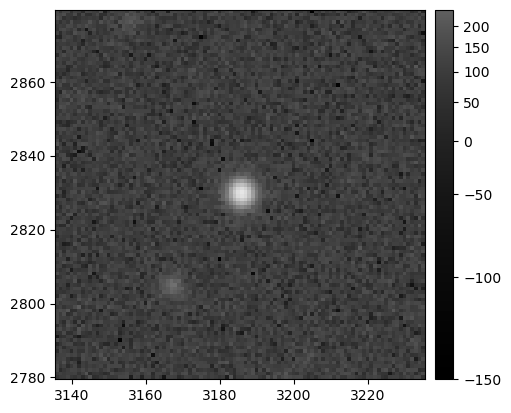

In [38]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(image_i.image)
plt.show()

In [51]:
type(image_r)

lsst.afw.image.exposure.ExposureF

In [39]:
from astropy.visualization import make_lupton_rgb

In [50]:
image = make_lupton_rgb(np.array(image_r), np.array(image_g), np.array(image_i))
plt.imshow(image)

NotImplementedError: This arithmetic operation is not implemented, in order to prevent the accidental proliferation of temporaries. Please use the in-place arithmetic operations (e.g., += instead of +) or operate on the underlying arrays.

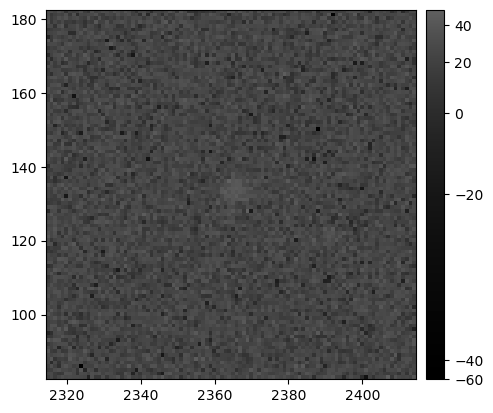

In [24]:
for index, row in variable_stars[0:1].iterrows():
    for band in ['r']:
        for visit in ccd_results['ccdVisitId'][2:4]:
            for detector in ccd_results['detector'][2:4]:
                #deepCoadd= get_cutout_image(row['ra'],row['dec'],visit,detector,band,datasetType='deepCoadd')
                deepCoadd= get_cutout_image(row['ra'],row['dec'],visit,detector,band,datasetType='calexp')
                figout = make_fig(deepCoadd, row['ra'],row['dec'],batch_dir+"/coadd_images/"+str(row['id_truth_type'])+\
                                  "_"+band+"_"+str(visit)+".png")
                remove_figure(figout)

LookupError: Dataset calexp with data ID {instrument: 'LSSTCam-imSim', detector: 180, visit: 1006101180} could not be found in collections ('2.2i/runs/DP0.2',).